<a href="https://colab.research.google.com/github/yugonsan/pytorch_practice/blob/main/%E7%AC%AC5%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot

In [4]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

- 線形関数（nn.Linear）
- カスタム定義により学習モデルを作る
- 平均2乗誤差による損失関数クラス（nn.MSELoss）を利用する



In [5]:
#入力1、出力1の線形関数
# 乱数の種固定
torch.manual_seed(123)
# 入力1、出力1の線形関数
l1 = nn.Linear(1, 1)
# 線形関数の表示
print(l1)

Linear(in_features=1, out_features=1, bias=True)


In [6]:
# named_parametersという関数を呼び出すと、パラメータ名、パラメータ参照のリストを返してくれます
print(l1.named_parameters)
for param in l1.named_parameters():
    print('name:', param[0])
    print('tensor:',param[1])
    print('shape:',param[1].shape)

<bound method Module.named_parameters of Linear(in_features=1, out_features=1, bias=True)>
name: weight
tensor: Parameter containing:
tensor([[-0.4078]], requires_grad=True)
shape: torch.Size([1, 1])
name: bias
tensor: Parameter containing:
tensor([0.0331], requires_grad=True)
shape: torch.Size([1])


結果を見ると[1,1]というshapeを持つ変数weightと[1]というshapeを持つ変数biasがあることがわかりました。

乱数値じゃなくて、線形関数を指定する事もできるよ


In [7]:
# 初期設定 y=2x+1
nn.init.constant_(l1.weight, 2.0)
nn.init.constant_(l1.bias, 1.0)
print(l1.weight)
print(l1.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


In [8]:
# テスト用データを作成
x_np = np.arange(-2, 2.1, 1)
# テンソル変数化
x = torch.tensor(x_np).float()
# サイズを（N,1）に変化
x = x.view(-1,1)
# 結果を確認
print(x.shape)
print(x)

torch.Size([5, 1])
tensor([[-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.]])


- 配列をテンソル変数化する際にfloat関数をかけて、データ型を変換している点です。この指定をしないとxはdoubleのデータ型になり、その状態で線形関数を呼び出すとエラーになる。
- 入力変数は1次元テンソルで表現できているのに、わざわざshapeが[5,1]の2次元テンソルに変換している点です。


In [9]:
# 1次関数のテスト
y = l1(x)
print(y.shape)
print(y.data)

torch.Size([5, 1])
tensor([[-3.],
        [-1.],
        [ 1.],
        [ 3.],
        [ 5.]])


In [10]:
# 入力2と出力1 #重回帰と同じパターン
l2 = nn.Linear(2, 1)
# 初期値設定
nn.init.constant_(l2.weight, 1.0)
nn.init.constant_(l2.bias, 2.0)
# 結果確認
print(l2.weight)
print(l2.bias)

Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([2.], requires_grad=True)


In [11]:
# 2次元NumPy配列
x2_np = np.array([[0,0],[0,1],[1,0],[1,1]])
# テンソル変数化、floatに直す
x2 = torch.tensor(x2_np).float()
# 結果確認
print(x2.shape)
print(x2)

torch.Size([4, 2])
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])


In [12]:
# 関数呼び出しテストの実装と結果
y2 = l2(x2)
# shpae確認
print(y2.shape)
print(y2.data)

torch.Size([4, 1])
tensor([[2.],
        [3.],
        [3.],
        [4.]])


In [13]:
# 2入力3出力の線形関数の定義
l3 = nn.Linear(2, 3)
# 初期値設定
nn.init.constant_(l3.weight[0,:], 1.0)
nn.init.constant_(l3.weight[1,:], 2.0)
nn.init.constant_(l3.weight[2,:], 3.0)
nn.init.constant_(l3.bias, 2.0)
# 結果確認
print(l3.weight)
print(l3.bias)

Parameter containing:
tensor([[1., 1.],
        [2., 2.],
        [3., 3.]], requires_grad=True)
Parameter containing:
tensor([2., 2., 2.], requires_grad=True)


In [14]:
# 関数値計算
y3 = l3(x2)
# shape確認
print(y3.shape)
# 値確認
print(y3.data)

torch.Size([4, 3])
tensor([[2., 2., 2.],
        [3., 4., 5.],
        [3., 4., 5.],
        [4., 6., 8.]])


カスタムクラスによるモデル定義は予測関数に関わるものです

In [15]:
# モデルのクラス定義

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        #  親クラスnn.Modulesの初期化呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = nn.Linear(n_input, n_output)   
        
    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1

- nn.Moduleである
- forward関数が定義されていてここで関数の予測処理を実装する

In [16]:
# ダミー入力
inputs = torch.ones(100,1)

# インスタンスの生成 (１入力1出力の線形モデル)
n_input = 1
n_output = 1
net = Net(n_input, n_output)

# 予測
outputs = net(inputs)

- 損失関数は損失計算と勾配計算を担います
- 損失lossとは予測関数と損失関数を組み合わせて出来上がった合成関数を計算すること
- この合成関数（損失）はweightとbiasを引数とします
- 合成関数（損失）をパラメターで微分することが勾配計算であり、勾配計算の結果が勾配効果法のパラメタ修正で使います。

In [17]:
# 損失関数（平均2乗誤差）
criterion = nn.MSELoss
# 誤差計算
loss = criterion(outputs, labels1) / 2.0


NameError: ignored

In [17]:
# 学習用データ準備

# 「ボストン・データセット」はscikit-learnのライブラリでも取得できるが、
# その場合、将来版で利用できなくなる予定のため、別Webサイトから取得する
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", 
    skiprows=22, header=None)
x_org = np.hstack([raw_df.values[::2, :], 
    raw_df.values[1::2, :2]])
yt = raw_df.values[1::2, 2]
feature_names = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT'])

# 結果確認
print('元データ', x_org.shape, yt.shape)
print('項目名: ', feature_names)

元データ (506, 13) (506,)
項目名:  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [18]:
# データ絞り込み (項目 RMのみ)
x = x_org[:,feature_names == 'RM']
print('絞り込み後', x.shape)
print(x[:5,:])

# 正解データ yの表示
print('正解データ')
print(yt[:5])

絞り込み後 (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]


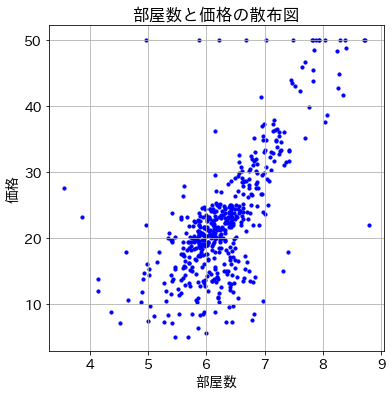

In [19]:
# 散布図の表示

plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格')
plt.title('部屋数と価格の散布図')
plt.show()

In [20]:
# モデル定義
# 入力次元数
n_input = x.shape[1]
print(x.shape)
print(n_input)
# 出力次元数
n_output = 1
print(f'入力次元数:{n_input} 出力次元数:{n_output}')

(506, 1)
1
入力次元数:1 出力次元数:1


In [21]:
# 機械学習モデル（予測モデル）クラス定義

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        #  親クラスnn.Modulesの初期化呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = nn.Linear(n_input, n_output)   
        
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        nn.init.constant_(self.l1.weight, 1.0)
        nn.init.constant_(self.l1.bias, 1.0)

    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1

- 入力、出力1次元で、重みl1.weightはshape=[1,1]の2階テンソル、バイアスlib.biasはshape=[1]の1階テンソルです。
- forwardの定義：Pytorchではモデルのクラスの内部で必ずforward関数を定義し、入力テンソルinputsを入力として出力テンソルoutputsを出力するための処理を記述する

In [22]:
# インスタンスの生成
# １入力1出力の線形モデル

net = Net(n_input, n_output)

In [23]:
# モデル内のパラメタの確認
# モデル内のパラメタ取得には、named_parameres関数を利用する
# 結果の第一要素が名前、第二要素が値
for parameter in net.named_parameters():
    print(f'変数名: {parameter[0]}')
    print(f'変数名: {parameter[1].data}')

変数名: l1.weight
変数名: tensor([[1.]])
変数名: l1.bias
変数名: tensor([1.])


named_parameters() は PyTorch の関数で、nn.Module クラスに組み込まれているメソッドです。これはモジュールのパラメータに対するイテレータを返し、パラメータの名前とパラメータそのものを返します。これはデバッグやモデルのパラメータを検査するのに便利です。

In [24]:
# parameters関数の場合は、パラメーター変数だけが名前なしにリスト形式で帰ってくる
print(net.parameters)
for parameter in net.parameters():
    print(parameter)

<bound method Module.parameters of Net(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)>
Parameter containing:
tensor([[1.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


In [25]:
# モデル概要の表示
print(net)

Net(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)


In [26]:
# モデルのサマリー表示
from torchinfo import summary
summary(net,(1,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [27]:
# 損失関数と最適化関数の定義
# 損失関数：平均2乗誤差
criterion = nn.MSELoss()
# 学習率
lr = 0.01
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr = lr)

In [28]:
# 勾配降下法（最適なパラメータ値、l1.weight, l1.biasを見つける）
# 入力変数x と正解値 ytのテンソル変数化

inputs = torch.tensor(x).float()
labels = torch.tensor(yt).float()

# 次元数確認

print(inputs.shape)
print(labels.shape)

torch.Size([506, 1])
torch.Size([506])


In [29]:
# 損失計算用にlabels変数を(N,1)次元の行列に変換する
labels1 = labels.view((-1, 1))
# 次元確認
print(labels1.shape)

torch.Size([506, 1])


予測計算、損失計算、勾配計算、パラメーター修正を繰り返せばいける


In [30]:
# 予測計算
outputs = net(inputs)
# 入力テンソルを引数にnetを関数としてよび、結果を出力テンソルに代入します
print(outputs)

tensor([[7.5750],
        [7.4210],
        [8.1850],
        [7.9980],
        [8.1470],
        [7.4300],
        [7.0120],
        [7.1720],
        [6.6310],
        [7.0040],
        [7.3770],
        [7.0090],
        [6.8890],
        [6.9490],
        [7.0960],
        [6.8340],
        [6.9350],
        [6.9900],
        [6.4560],
        [6.7270],
        [6.5700],
        [6.9650],
        [7.1420],
        [6.8130],
        [6.9240],
        [6.5990],
        [6.8130],
        [7.0470],
        [7.4950],
        [7.6740],
        [6.7130],
        [7.0720],
        [6.9500],
        [6.7010],
        [7.0960],
        [6.9330],
        [6.8410],
        [6.8500],
        [6.9660],
        [7.5950],
        [8.0240],
        [7.7700],
        [7.1690],
        [7.2110],
        [7.0690],
        [6.6820],
        [6.7860],
        [7.0300],
        [6.3990],
        [6.6020],
        [6.9630],
        [7.1150],
        [7.5110],
        [6.9980],
        [6.8880],
        [8

In [31]:
print(labels1)

tensor([[24.0000],
        [21.6000],
        [34.7000],
        [33.4000],
        [36.2000],
        [28.7000],
        [22.9000],
        [27.1000],
        [16.5000],
        [18.9000],
        [15.0000],
        [18.9000],
        [21.7000],
        [20.4000],
        [18.2000],
        [19.9000],
        [23.1000],
        [17.5000],
        [20.2000],
        [18.2000],
        [13.6000],
        [19.6000],
        [15.2000],
        [14.5000],
        [15.6000],
        [13.9000],
        [16.6000],
        [14.8000],
        [18.4000],
        [21.0000],
        [12.7000],
        [14.5000],
        [13.2000],
        [13.1000],
        [13.5000],
        [18.9000],
        [20.0000],
        [21.0000],
        [24.7000],
        [30.8000],
        [34.9000],
        [26.6000],
        [25.3000],
        [24.7000],
        [21.2000],
        [19.3000],
        [20.0000],
        [16.6000],
        [14.4000],
        [19.4000],
        [19.7000],
        [20.5000],
        [25.

In [32]:
#  損失計算
loss = criterion(outputs, labels1)

# 損失値の取得
print(f'{loss.item():.5f}')

308.44986


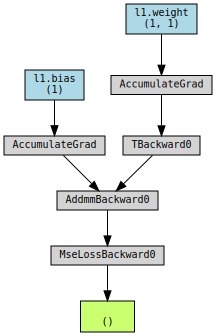

In [33]:
# 損失グラフの取得
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [34]:
# 予測値の計算
outputs = net(inputs)
# 損失の計算
loss = criterion(outputs, labels1)
# 勾配計算
loss.backward()
# 勾配の結果が取得可能
print(net.l1.weight.grad)
print(net.l1.bias.grad)

tensor([[-199.6421]])
tensor([-30.4963])


勾配が重み、バイアスそれぞれ1つで表される理由が掴めていないな。複数あるやん？


In [35]:
# パラメタ修正
optimizer.step()
# パラメタとバイアス値が変わる
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[2.9964]], requires_grad=True)
Parameter containing:
tensor([1.3050], requires_grad=True)


In [36]:
# パラメタの修正が終わったら勾配値を初期化する必要がある
optimizer.zero_grad()
# 勾配値が全て0になっている
print(net.l1.weight.grad)
print(net.l1.bias.grad)

tensor([[0.]])
tensor([0.])


In [46]:
# 学習率
lr = 0.01

# インスタンス生成　(パラメータ値初期化)
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

In [47]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 損失計算
    # 「ディープラーニングの数学」に合わせて2で割った値を損失とした
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 154.22493
Epoch 100 loss: 29.61752
Epoch 200 loss: 29.43177
Epoch 300 loss: 29.25043
Epoch 400 loss: 29.07340
Epoch 500 loss: 28.90057
Epoch 600 loss: 28.73186
Epoch 700 loss: 28.56715
Epoch 800 loss: 28.40636
Epoch 900 loss: 28.24939
Epoch 1000 loss: 28.09615
Epoch 1100 loss: 27.94655
Epoch 1200 loss: 27.80050
Epoch 1300 loss: 27.65792
Epoch 1400 loss: 27.51873
Epoch 1500 loss: 27.38285
Epoch 1600 loss: 27.25020
Epoch 1700 loss: 27.12070
Epoch 1800 loss: 26.99428
Epoch 1900 loss: 26.87086
Epoch 2000 loss: 26.75037
Epoch 2100 loss: 26.63275
Epoch 2200 loss: 26.51792
Epoch 2300 loss: 26.40582
Epoch 2400 loss: 26.29639
Epoch 2500 loss: 26.18955
Epoch 2600 loss: 26.08525
Epoch 2700 loss: 25.98343
Epoch 2800 loss: 25.88404
Epoch 2900 loss: 25.78700
Epoch 3000 loss: 25.69226
Epoch 3100 loss: 25.59978
Epoch 3200 loss: 25.50950
Epoch 3300 loss: 25.42136
Epoch 3400 loss: 25.33532
Epoch 3500 loss: 25.25132
Epoch 3600 loss: 25.16932
Epoch 3700 loss: 25.08927
Epoch 3800 loss: 25.011

In [48]:
# 損失初期値と最終値

print(f'損失初期値: {history[0,1]:.5f}')
print(f'損失最終値: {history[-1,1]:.5f}')

損失初期値: 154.22493
損失最終値: 21.80033


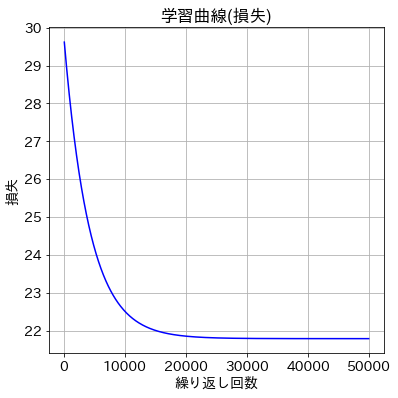

In [49]:

# 学習曲線の表示 (損失) 
# 最初の1つを除く

plt.plot(history[1:,0], history[1:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()

In [50]:
# 回帰直線の算出

# xの最小値、最大値
xse = np.array((x.min(), x.max())).reshape(-1,1)
Xse = torch.tensor(xse).float()

with torch.no_grad():
  Yse = net(Xse)

print(Yse.numpy())

[[-2.2189]
 [45.2121]]


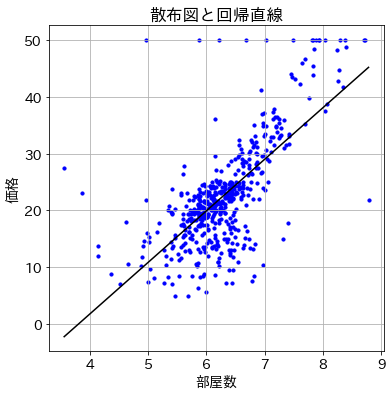

In [51]:
# 散布図と回帰直線の描画

plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格')
plt.plot(Xse.data, Yse.data, c='k')
plt.title('散布図と回帰直線')
plt.show()

In [52]:
# 列(LSTAT: 低所得者率)の追加

x_add = x_org[:,feature_names == 'LSTAT']
x2 = np.hstack((x, x_add))

# shapeの表示
print(x2.shape)

# 入力データxの表示
print(x2[:5,:])

(506, 2)
[[6.575 4.98 ]
 [6.421 9.14 ]
 [7.185 4.03 ]
 [6.998 2.94 ]
 [7.147 5.33 ]]


In [53]:
# 今度は入力次元数=2

n_input = x2.shape[1]
print(n_input)

# モデルインスタンスの生成
net = Net(n_input, n_output)

2


In [54]:
# モデル内のパラメータの確認
# predict.weight が2次元に変わった

for parameter in net.named_parameters():
    print(f'変数名: {parameter[0]}')
    print(f'変数値: {parameter[1].data}')

変数名: l1.weight
変数値: tensor([[1., 1.]])
変数名: l1.bias
変数値: tensor([1.])


In [55]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
)


In [56]:
# モデルのサマリー表示

from torchinfo import summary
summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [57]:
# 入力変数x2 のテンソル変数化 
# labels, labels1は前のものをそのまま利用

inputs = torch.tensor(x2).float()

In [58]:
# 初期化処理

# 学習率
lr = 0.01

# インスタンス生成　(パラメータ値初期化)
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

In [59]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 誤差計算
    # 「ディープラーニングの数学」に合わせて2で割った値を損失とした
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 112.06398
Epoch 100 loss: 3753837073642659568666615480320.00000
Epoch 200 loss: inf
Epoch 300 loss: nan
Epoch 400 loss: nan
Epoch 500 loss: nan
Epoch 600 loss: nan
Epoch 700 loss: nan
Epoch 800 loss: nan
Epoch 900 loss: nan
Epoch 1000 loss: nan
Epoch 1100 loss: nan
Epoch 1200 loss: nan
Epoch 1300 loss: nan
Epoch 1400 loss: nan
Epoch 1500 loss: nan
Epoch 1600 loss: nan
Epoch 1700 loss: nan
Epoch 1800 loss: nan
Epoch 1900 loss: nan
Epoch 2000 loss: nan
Epoch 2100 loss: nan
Epoch 2200 loss: nan
Epoch 2300 loss: nan
Epoch 2400 loss: nan
Epoch 2500 loss: nan
Epoch 2600 loss: nan
Epoch 2700 loss: nan
Epoch 2800 loss: nan
Epoch 2900 loss: nan
Epoch 3000 loss: nan
Epoch 3100 loss: nan
Epoch 3200 loss: nan
Epoch 3300 loss: nan
Epoch 3400 loss: nan
Epoch 3500 loss: nan
Epoch 3600 loss: nan
Epoch 3700 loss: nan
Epoch 3800 loss: nan
Epoch 3900 loss: nan
Epoch 4000 loss: nan
Epoch 4100 loss: nan
Epoch 4200 loss: nan
Epoch 4300 loss: nan
Epoch 4400 loss: nan
Epoch 4500 loss: nan
Epoch 

In [60]:
# 繰り返し回数
#num_epochs = 50000
num_epochs = 2000

# 学習率
#l r = 0.01
lr = 0.001

# モデルインスタンスの生成
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

In [61]:
# 繰り返し計算メインループ

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 誤差計算
    loss = criterion(outputs, labels1) / 2.0

    #勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 112.06398
Epoch 100 loss: 25.35892
Epoch 200 loss: 16.39105
Epoch 300 loss: 15.40301
Epoch 400 loss: 15.29414
Epoch 500 loss: 15.28211
Epoch 600 loss: 15.28076
Epoch 700 loss: 15.28059
Epoch 800 loss: 15.28054
Epoch 900 loss: 15.28051
Epoch 1000 loss: 15.28048
Epoch 1100 loss: 15.28046
Epoch 1200 loss: 15.28043
Epoch 1300 loss: 15.28040
Epoch 1400 loss: 15.28037
Epoch 1500 loss: 15.28034
Epoch 1600 loss: 15.28031
Epoch 1700 loss: 15.28028
Epoch 1800 loss: 15.28026
Epoch 1900 loss: 15.28023


In [62]:
# 損失初期値、最終値

print(f'損失初期値: {history[0,1]:.5f}')
print(f'損失最終値: {history[-1,1]:.5f}')

損失初期値: 112.06398
損失最終値: 15.28023


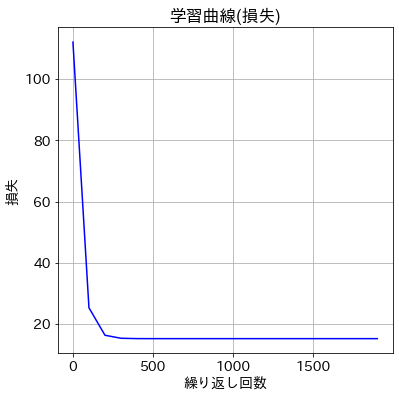

In [63]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()